### Importing the important libraries

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import calendar
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading the datasets

In [4]:
df_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_sample_sub = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_transaction = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [6]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
# getting the number of holidays that were transferred
df_holidays['transferred'].value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

In [9]:
### getting a list of all the transferred holidays
df_holidays[df_holidays['transferred'] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [11]:
#removing the duplicates from the holidays dataset after carefully watching each entries from the abve dataframe
to_drop_index = [32,35,40,54,86,110,111,112,151,157,205,224,236,242,244,249,265,282,291,305,344]
df_holidays = df_holidays.drop(to_drop_index)
df_holidays.reset_index(inplace=True)
df_holidays = df_holidays.drop('index', axis = 1)

#separating the locale of the holidays
df_holidays_national = df_holidays[df_holidays['locale']=='National']
df_holidays_local = df_holidays[df_holidays['locale']=='Local']
df_holidays_regional = df_holidays[df_holidays['locale']=='Regional']

In [12]:
### dropping the id columns
df_train = df_train.drop('id',axis = 1)
df_test = df_test.drop('id',axis = 1)

In [13]:
#merging the training ad testing datasets
df = pd.concat([df_train, df_test])

#merging the stores dataset
df = df.merge(df_stores, on = ['store_nbr'], how = 'left')

In [15]:
#merging the holidays dataset

#merging the national holidays
df.columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state','store_type', 'cluster']
df_holidays_national.columns = ['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
df = df.merge(df_holidays_national, on = ['date'], how = 'left')

#merging the local holidays
df.columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state','store_type', 'cluster', 'type_nationa', 'locale_national', 'locale_name_country','description_national', 'transferred_national']
df_holidays_local.columns = ['date', 'type_local', 'locale_local', 'city', 'description_local', 'transferred_local']
df = df.merge(df_holidays_local, on = ['date','city'], how = 'left')

#merging the regional holidays
df_holidays_regional.columns = ['date', 'type_regional', 'locale_regional', 'state', 'description_regional', 'transferred_regional']
df = df.merge(df_holidays_regional, on = ['date','state'], how = 'left')

In [ ]:
df.columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state','store_type', 'cluster', 'type_national', 'locale_national','locale_name_country', 'description_national', 'transferred_national','type_local', 'locale_local', 'description_local', 'transferred_local','type_regional', 'locale_regional', 'description_regional','transferred_regional']

In [18]:
#merging the type columns 
type_holiday = []
for i in tqdm(range(len(df))):
    if type(df['type_national'][i]) != float:
        type_holiday.append(df['type_national'][i])
    else:
        if type(df['type_local'][i]) != float:
            type_holiday.append(df['type_local'][i])
        else:
            if type(df['type_regional']) != float:
                type_holiday.append(df['type_regional'][i])
            else:
                type_holiday.append(0)
                
df['Holiday_type'] = type_holiday
df = df.drop(['type_national', 'type_local','type_regional'], axis = 1)

100%|██████████| 3029400/3029400 [01:54<00:00, 26378.46it/s]


In [19]:
#merging the locale columns 
locale_holiday = []
for i in tqdm(range(len(df))):
    if type(df['locale_national'][i]) != float:
        locale_holiday.append(df['locale_national'][i])
    else:
        if type(df['locale_local'][i]) != float:
            locale_holiday.append(df['locale_local'][i])
        else:
            if type(df['locale_regional']) != float:
                locale_holiday.append(df['locale_regional'][i])
            else:
                locale_holiday.append(0)
                
df['locale'] = locale_holiday
df = df.drop(['locale_national', 'locale_local','locale_regional'], axis = 1)

100%|██████████| 3029400/3029400 [01:54<00:00, 26430.13it/s]


In [20]:
#merging the transferred columns 
transferred_holiday = []
for i in tqdm(range(len(df))):
    if type(df['transferred_national'][i]) != float:
        transferred_holiday.append(df['transferred_national'][i])
    else:
        if type(df['transferred_local'][i]) != float:
            transferred_holiday.append(df['transferred_local'][i])
        else:
            if type(df['transferred_regional']) != float:
                transferred_holiday.append(df['transferred_regional'][i])
            else:
                transferred_holiday.append(0)
                
df['transferred'] = transferred_holiday
df = df.drop(['transferred_national', 'transferred_local','transferred_regional'], axis = 1)

100%|██████████| 3029400/3029400 [01:54<00:00, 26496.78it/s]


In [21]:
#merging the transferred columns 
description_holiday = []
for i in tqdm(range(len(df))):
    if type(df['description_national'][i]) != float:
        description_holiday.append(df['description_national'][i])
    else:
        if type(df['description_local'][i]) != float:
            description_holiday.append(df['description_local'][i])
        else:
            if type(df['description_regional']) != float:
                description_holiday.append(df['description_regional'][i])
            else:
                description_holiday.append(0)
                
df['Holiday Description'] = description_holiday
df = df.drop(['description_national', 'description_local','description_regional'], axis = 1)

100%|██████████| 3029400/3029400 [01:54<00:00, 26465.75it/s]


In [26]:
### dropping the unrequired columns
df = df.drop('locale_name_country', axis = 1)
df = df.drop('Holiday Description', axis = 1)

### modifying the columns
df['transferred'] = df['transferred'].fillna(False)
df['Holiday_type'] = df['Holiday_type'].fillna('Working')
df['locale'] = df['locale'].fillna('locale not defined')

In [57]:
def remove_warnings():
    warnings.filterwarnings('ignore')
    warnings.warn('Error: A warning just appeared')

In [32]:
remove_warnings()
### Here we were having missing values at each christmas so filling the missed values with zeros
christmas_holiday = df[df['date']=='2017-08-31']

christmas_holiday['date'] = '2013-12-25'
christmas_holiday['sales'] = 0
christmas_holiday['onpromotion'] = 0

christmas_holiday_2013 = christmas_holiday
df = pd.concat([df,christmas_holiday_2013])

christmas_holiday_2013['date'] = '2014-12-25'
df = pd.concat([df,christmas_holiday_2013])

christmas_holiday_2013['date'] = '2015-12-25'
df = pd.concat([df,christmas_holiday_2013])

christmas_holiday_2013['date'] = '2016-12-25'
df = pd.concat([df,christmas_holiday_2013])

In [33]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'])

### Interpolating the oil price data

Here on plotting the oil price data we find out we have some missing values in the dataset, to fill those values we will use spline interpolation method

In [36]:
#resampling to get the oil data
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil = df_oil.set_index('date')

<Axes: xlabel='date'>

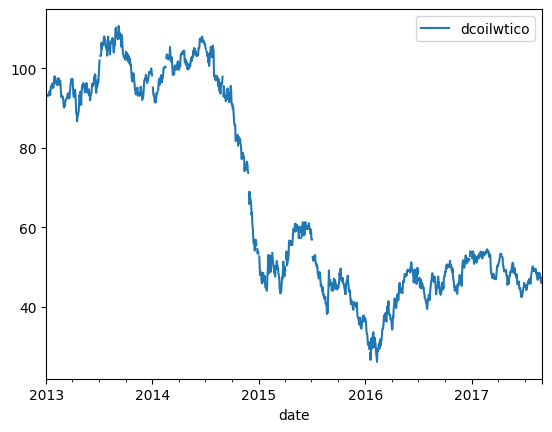

In [37]:
df_oil.plot()

In [38]:
df_oil_upsampled = df_oil.resample('D')
df_oil_interpolated = df_oil_upsampled.interpolate(method='spline', order=2)

<Axes: xlabel='date'>

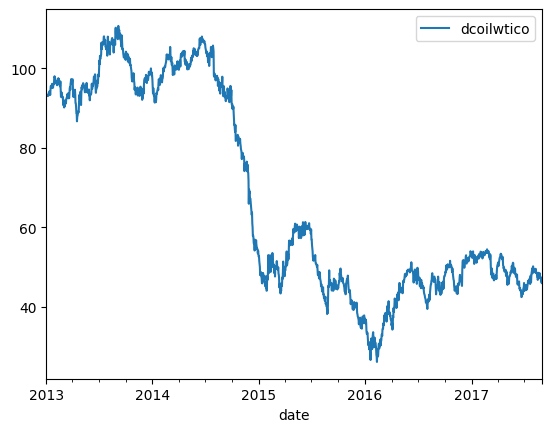

In [39]:
df_oil_interpolated.plot()

Interpolating the oil price data

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
dcoilwtico = list(df_oil_interpolated['dcoilwtico'])
dcoilwtico = dcoilwtico[::-1]
train = df_oil_interpolated
train['target'] = dcoilwtico
train = train.drop('dcoilwtico',axis = 1)
train = train[:-1]

In [43]:
ARMAmodel = SARIMAX(train, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79049D+03    |proj g|=  8.89464D+03

At iterate    5    f=  1.81647D+01    |proj g|=  3.67969D+01

At iterate   10    f=  2.93821D+00    |proj g|=  1.40503D+00

At iterate   15    f=  1.82489D+00    |proj g|=  1.34260D-01


 This problem is unconstrained.



At iterate   20    f=  1.53427D+00    |proj g|=  7.18981D-02

At iterate   25    f=  1.46534D+00    |proj g|=  8.63671D-03

At iterate   30    f=  1.45787D+00    |proj g|=  9.99779D-03

At iterate   35    f=  1.45717D+00    |proj g|=  2.56446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     45      1     0     0   6.135D-06   1.457D+00
  F =   1.4571650406058718     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [44]:
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

df_oil_interpolated['dcoilwtico'] = df_oil_interpolated['dcoilwtico'].fillna(93.102763)
df_oil_interpolated = df_oil_interpolated.drop('target',axis = 1)

In [45]:
df_oil_interpolated.to_csv('df_oil_interpolated.csv')

In [46]:
### Merging the oil price data
df = df.merge(df_oil_interpolated, on = ['date'], how = 'left')
df.columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state','store_type', 'cluster', 'Holiday_type', 'locale', 'transferred','Oil Price']

In [47]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [63]:
df.to_csv('df.csv')

### Exploratory Data Analysis and Visualizations

In [4]:
df = pd.read_csv('/kaggle/input/df-sales/df (1).csv')

In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
df_test = df.loc['2017-08-16':]
df_train = df.loc[:'2017-08-15']

<Axes: ylabel='date'>

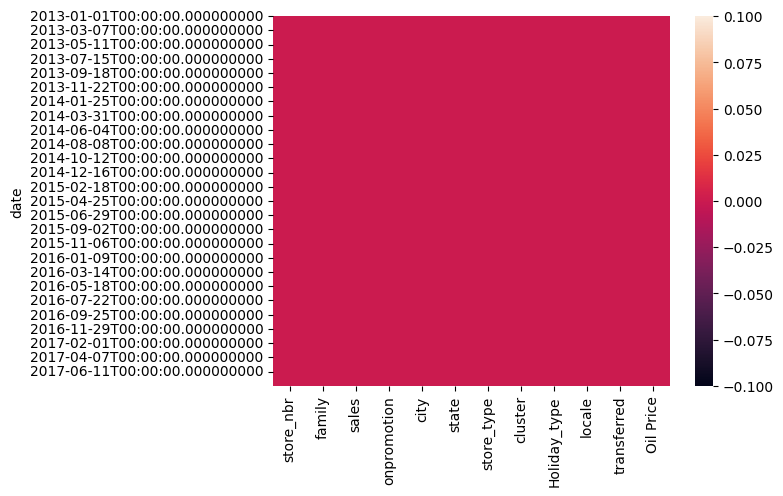

In [20]:
sns.heatmap(df_train.isnull())

<Axes: ylabel='date'>

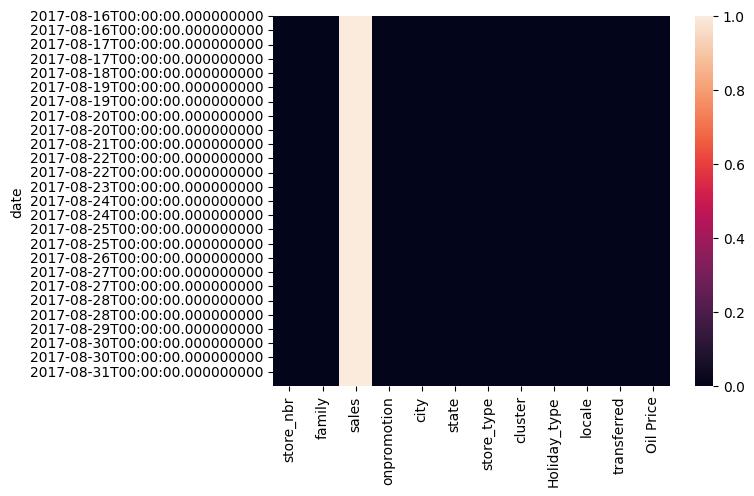

In [21]:
sns.heatmap(df_test.isnull())

In [7]:
df_test = df_test.drop('sales', axis = 1)

<Axes: ylabel='date'>

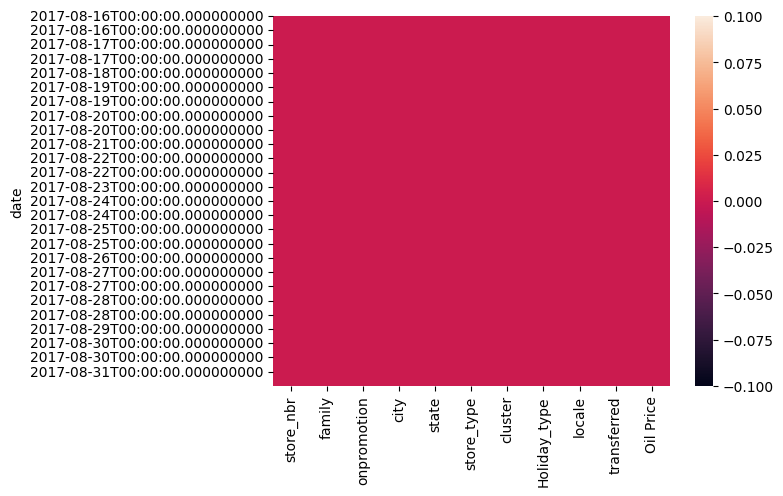

In [25]:
sns.heatmap(df_test.isnull())

1) Plotting the relationship between store type and sales

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33'),
  Text(33, 0, '34'),
  Text(34, 0, '35'),
  Text(35, 0, '36'),
  Text(36, 0,

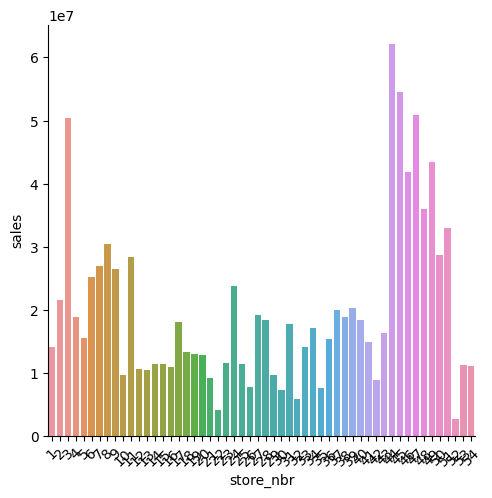

In [29]:
remove_warnings()
df_sales_by_store_type = df_train.groupby('store_nbr')['sales'].sum().reset_index()
sns.catplot(data = df_sales_by_store_type, x = 'store_nbr', y = 'sales',kind = 'bar')
plt.xticks(rotation = 45)

2) Plotting the relationship between the prodcut family and sales

In [16]:
df_sales_by_family = (df_train.groupby('family').sum()['sales']).reset_index()
df_sales_by_family = df_sales_by_family.sort_values(by='sales')
df_sales_by_family_top10 = df_sales_by_family[-10:]

/tmp/ipykernel_33/1648944776.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sales_by_family = (df_train.groupby('family').sum()['sales']).reset_index()


([<matplotlib.patches.Wedge at 0x7e8696885c60>,
 [Text(1.0968392471117427, 0.08332866250783894, '9'),
  Text(1.0712850393493547, 0.24969654476234082, '25'),
  Text(1.0114024855485861, 0.4325101296225818, '24'),
  Text(0.9065541494998893, 0.6230245372571873, '28'),
  Text(0.7383996533352036, 0.8153318048220929, '5'),
  Text(0.42897145907788087, 1.0129084298674753, '8'),
  Text(-0.11956233819829913, 1.0934828975729596, '7'),
  Text(-0.7902478909536137, 0.7651851219432887, '30'),
  Text(-1.0512181446016744, -0.32394507630185265, '3'),
  Text(0.5182903960096705, -0.9702448481719134, '12')],
 [Text(0.5982759529700414, 0.04545199773154851, '2.4%'),
  Text(0.584337294190557, 0.13619811532491316, '2.5%'),
  Text(0.5516740830265014, 0.23591461615777184, '3.1%'),
  Text(0.49448408154539414, 0.3398315657766476, '3.2%'),
  Text(0.4027634472737474, 0.4447264389938688, '4.2%'),
  Text(0.2339844322242986, 0.552495507200441, '6.5%'),
  Text(-0.06521582083543588, 0.5964452168579779, '9.8%'),
  Text(-0.

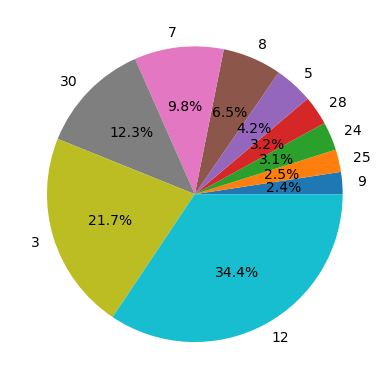

In [17]:
plt.pie(df_sales_by_family_top10['sales'], labels = df_sales_by_family_top10.index, autopct='%1.1f%%')

3) Exploring the relationship between the onpromotion variable i.e promotion by the stores and their sales

<Axes: xlabel='onpromotion', ylabel='sales'>

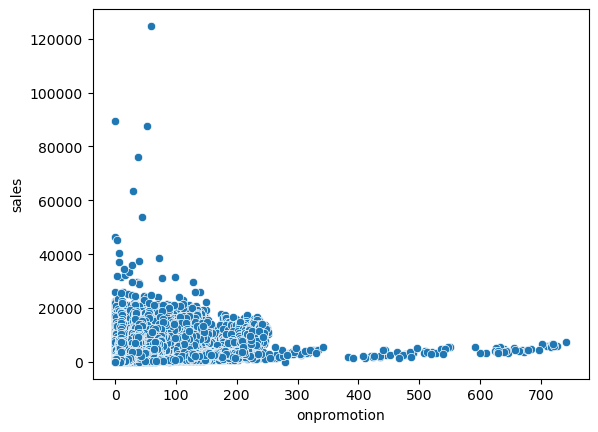

In [18]:
sns.scatterplot(data = df, x = 'onpromotion', y = 'sales')

4) Exploring the effect of oil prices on sales

<Axes: xlabel='Oil Price', ylabel='sales'>

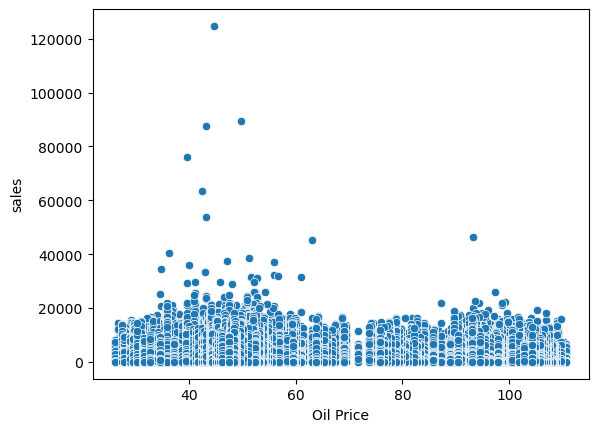

In [19]:
sns.scatterplot(data = df, x = 'Oil Price', y = 'sales')

5) Plotting the sales distribution by city

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'Quito'),
  Text(1, 0, 'Cuenca'),
  Text(2, 0, 'Machala'),
  Text(3, 0, 'Esmeraldas'),
  Text(4, 0, 'Libertad'),
  Text(5, 0, 'Playas'),
  Text(6, 0, 'Guayaquil'),
  Text(7, 0, 'Loja'),
  Text(8, 0, 'El Carmen'),
  Text(9, 0, 'Manta'),
  Text(10, 0, 'Ambato'),
  Text(11, 0, 'Santo Domingo'),
  Text(12, 0, 'Quevedo'),
  Text(13, 0, 'Guaranda'),
  Text(14, 0, 'Ibarra'),
  Text(15, 0, 'Cayambe'),
  Text(16, 0, 'Latacunga'),
  Text(17, 0, 'Riobamba'),
  Text(18, 0, 'Babahoyo'),
  Text(19, 0, 'Puyo'),
  Text(20, 0, 'Daule'),
  Text(21, 0, 'Salinas')])

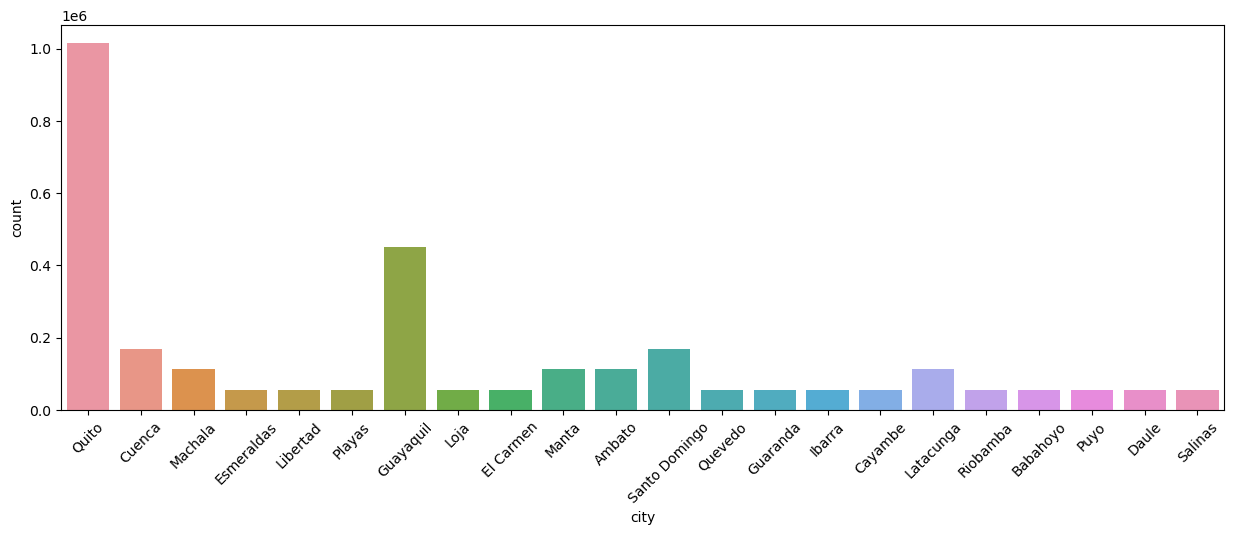

In [20]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x = 'city')
plt.xticks(rotation = 45)

6) Plotting the sales distribution by states

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Pichincha'),
  Text(1, 0, 'Azuay'),
  Text(2, 0, 'El Oro'),
  Text(3, 0, 'Esmeraldas'),
  Text(4, 0, 'Guayas'),
  Text(5, 0, 'Loja'),
  Text(6, 0, 'Manabi'),
  Text(7, 0, 'Tungurahua'),
  Text(8, 0, 'Santo Domingo de los Tsachilas'),
  Text(9, 0, 'Los Rios'),
  Text(10, 0, 'Bolivar'),
  Text(11, 0, 'Imbabura'),
  Text(12, 0, 'Cotopaxi'),
  Text(13, 0, 'Chimborazo'),
  Text(14, 0, 'Pastaza'),
  Text(15, 0, 'Santa Elena')])

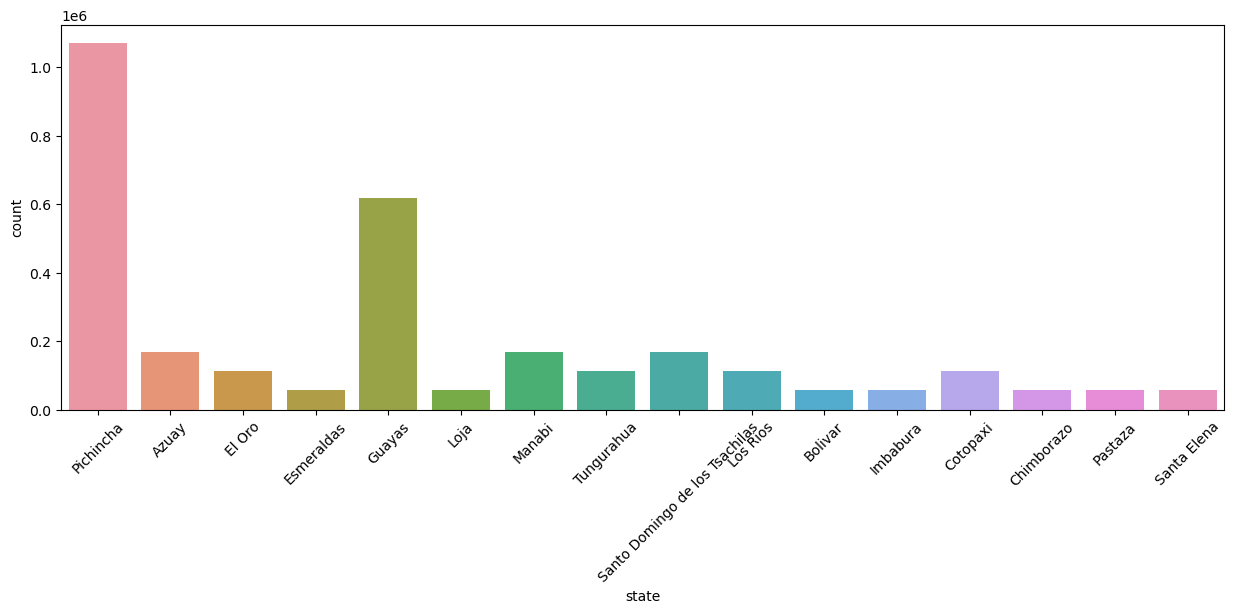

In [21]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x = 'state')
plt.xticks(rotation = 45)

7) Plotting the sales distribution by stores

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33'),
  Text(33, 0, '34'),
  Text(34, 0, '35'),
  Text(35, 0, '36'),
  Text(36, 0,

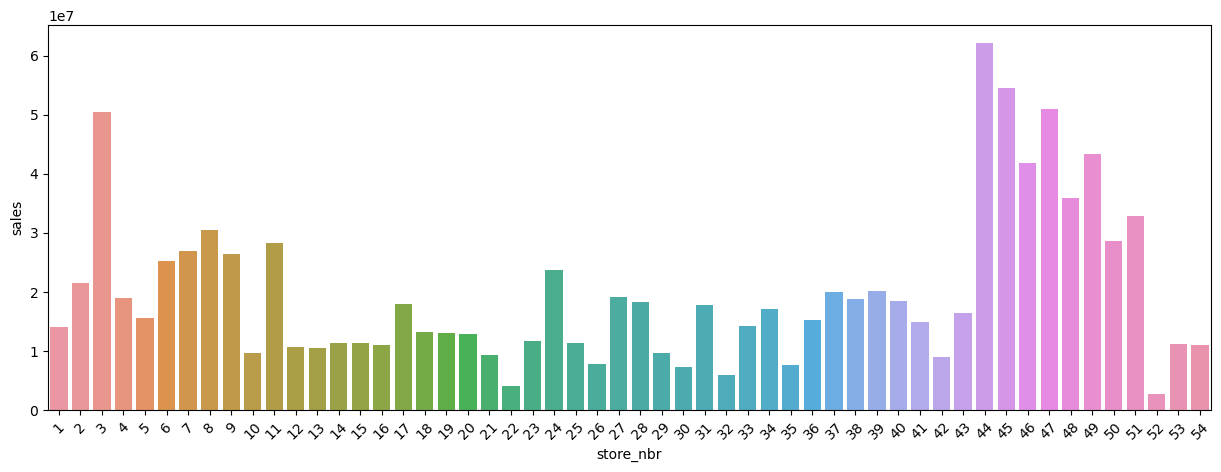

In [22]:
df_sales_by_stores = pd.DataFrame(df.groupby('store_nbr')['sales'].sum())
plt.figure(figsize = (15,5))
sns.barplot(data = df_sales_by_stores, x = df_sales_by_stores.index, y='sales')
plt.xticks(rotation = 45)

8) Plotting the sales distribution by month

In [27]:
df = df.sort_values(by = ['date'])

In [28]:
df['Month'] = df.index.month
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])
df['Year'] = df.index.year
df['Day'] = df.index.day_name()

In [30]:
df_sales_by_month = pd.DataFrame(df.groupby('Month')['sales'].sum())
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sales = [df_sales_by_month.loc['Jan']['sales'],df_sales_by_month.loc['Feb']['sales'],df_sales_by_month.loc['Mar']['sales'],df_sales_by_month.loc['Apr']['sales'],df_sales_by_month.loc['May']['sales'],df_sales_by_month.loc['Jun']['sales'],df_sales_by_month.loc['Jul']['sales'],df_sales_by_month.loc['Aug']['sales'],df_sales_by_month.loc['Sep']['sales'],df_sales_by_month.loc['Oct']['sales'],df_sales_by_month.loc['Nov']['sales'],df_sales_by_month.loc['Dec']['sales']]
df_sales_by_month = pd.DataFrame({'Month':months, 'Sales':sales })

<Axes: xlabel='Month', ylabel='Sales'>

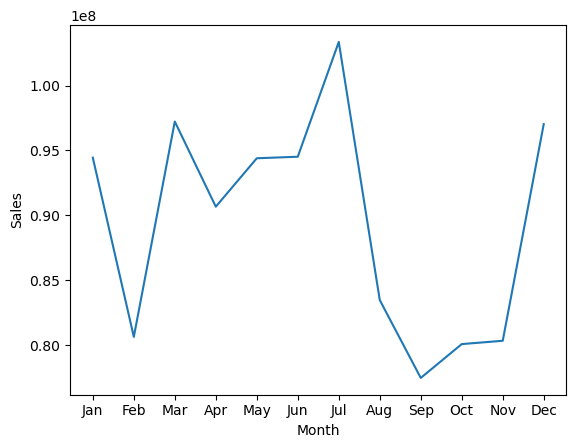

In [31]:
sns.lineplot(data = df_sales_by_month, x = 'Month',y = 'Sales')

9) Plotting the sales distribution by year

([<matplotlib.axis.XTick at 0x7e86639cba00>,
 [Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017')])

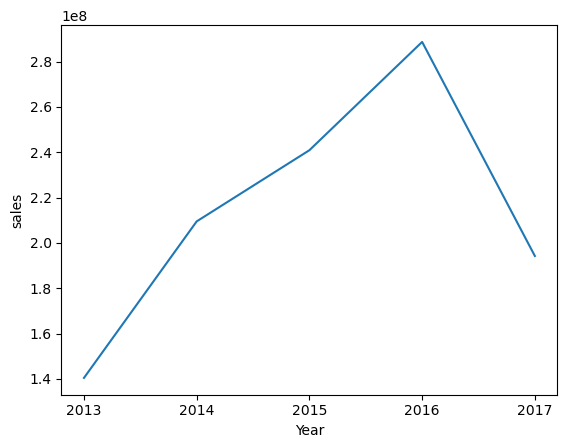

In [32]:
df_sales_by_year = pd.DataFrame(df.groupby('Year')['sales'].sum())
sns.lineplot(df_sales_by_year,x = 'Year',y = 'sales')
plt.xticks(range(2013,2018),[2013,2014,2015,2016,2017])

10) Plotting sales distribution, monthly year wise

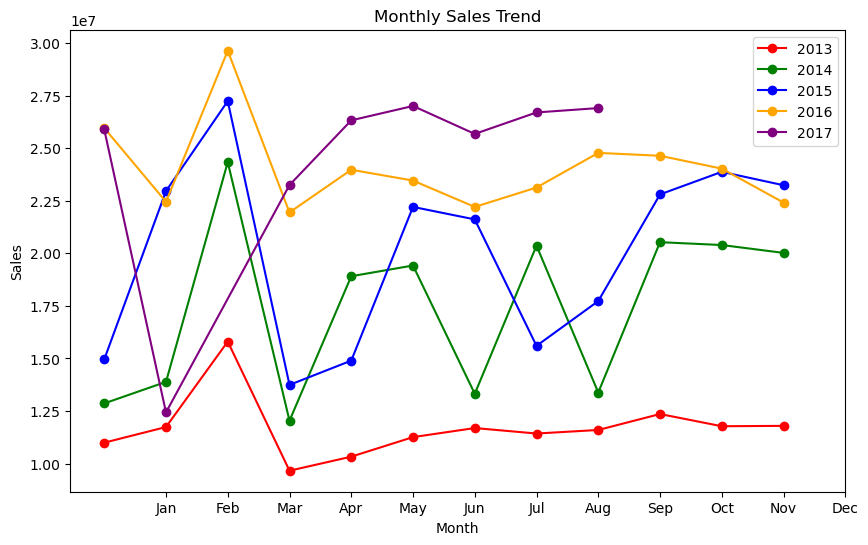

In [34]:
monthly_sales = df.groupby(['Month', 'Year'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
years = monthly_sales['Year'].unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])
for year in years:
    year_data = monthly_sales[monthly_sales['Year'] == year]
    plt.plot(year_data['Month'], year_data['sales'], marker='o', color=next(colors), label=str(year))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)
plt.legend()
plt.show()

11) Exploring the relationship between the sales and holidays

<Axes: xlabel='Holiday_type', ylabel='sales'>

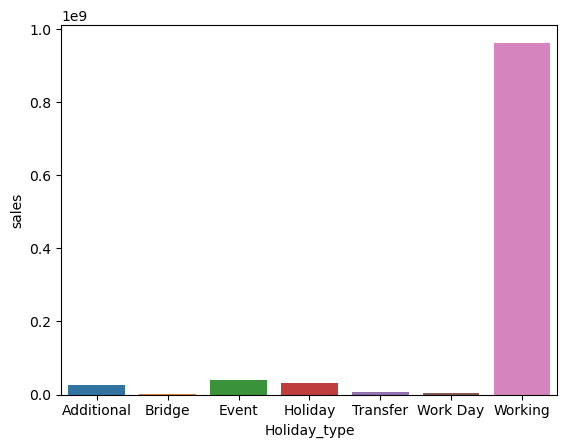

In [36]:
df_holiday_sales = df.groupby('Holiday_type')['sales'].sum().reset_index()
sns.barplot(data = df_holiday_sales, x = 'Holiday_type', y = 'sales')

### Data Manipulation and Modification

In [45]:
### Writing a function to classify all the holiday types to either holiday or non holiday
def func(x):
    if x == 'Working':
        return 'Non_Holiday'
    else:
        return 'Holiday'

In [ ]:
df['Holiday'] = df['Holiday_type'].apply(func)
df = df.drop('Holiday_type', axis = 1)
df.columns = ['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state','store_type', 'cluster', 'locale', 'transferred', 'Oil Price', 'Month','Year', 'Day', 'Holiday_type']

In [40]:
### dropping the not useful columns
oil_price = df.groupby('date')['Oil Price'].mean().reset_index()
df = df.drop(['state','store_type','cluster','city','locale','Month','Year','Day'], axis = 1)

### converting the data type to string and formulating a new variable "Feature"
df['transferred'] = df['transferred'].apply(str)
df['store_nbr'] = df['store_nbr'].apply(str)
df['Feature'] = df['store_nbr'] + '_' + df['family'] + '_' + df['Holiday_type']

### dealing with onpromotion
df = df.drop(['store_nbr','family','transferred'], axis = 1)
df['date'] = df.index
promotion = df_train['onpromotion'].value_counts().reset_index()

In [41]:
df = df.drop('Holiday_type', axis = 1)
df.columns = ['sales','onpromotion','Oil Price','Feature','date_index']
df = pd.DataFrame(df.groupby(['date_index','Feature'])['sales','Oil Price'].mean()).reset_index()
df = df.set_index('date_index')

/tmp/ipykernel_33/2599169595.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = pd.DataFrame(df.groupby(['date_index','Feature'])['sales','Oil Price'].mean()).reset_index()


In [42]:
## splitting the data into train and test set
df_train = df[:'2017-08-15']
df_test = df['2017-08-16':]

remove_warnings()
df_train['date'] = df_train.index
df_test['date'] = df_test.index

In [ ]:
### Pivoting the train and test data to get a unique dataset
### Train
df_train = df_train.pivot(index='date', columns='Feature', values='sales')
df_train = df_train.reset_index()
### Test
df_test = df_test.pivot(index='date', columns='Feature', values='sales')
df_test = df_test.reset_index()

<Axes: xlabel='Feature'>

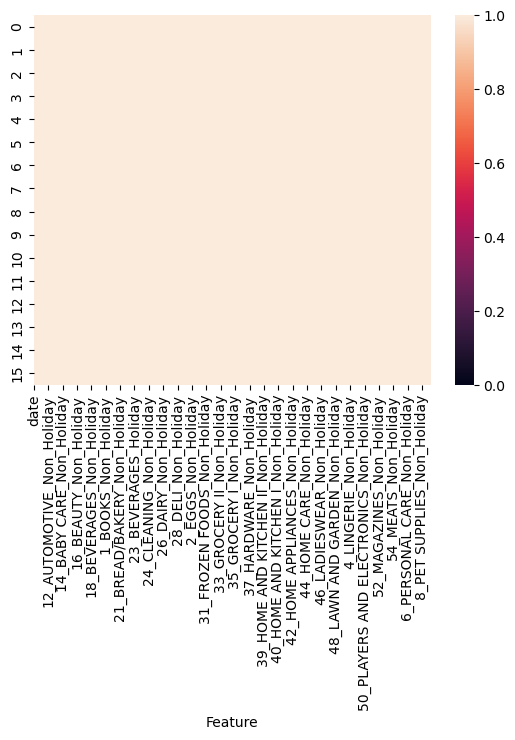

In [62]:
sns.heatmap(df_test.isnull())

<Axes: xlabel='Feature'>

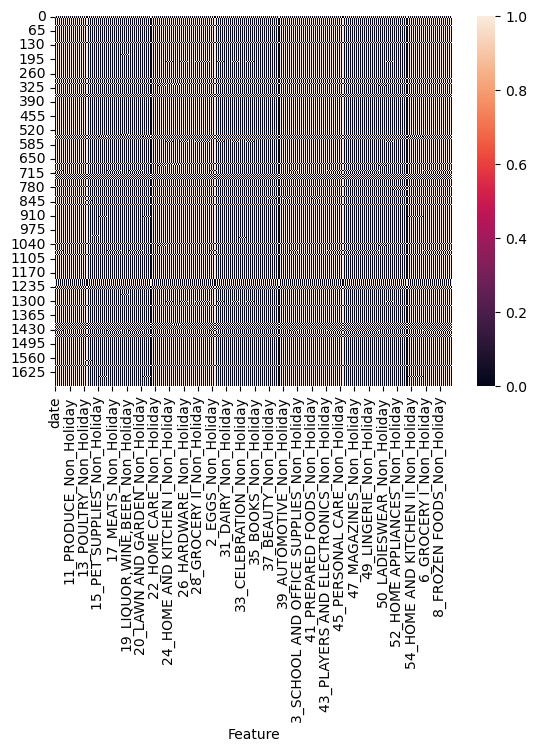

In [63]:
sns.heatmap(df_train.isnull())

In [64]:
### Filling the null values with zeros
df_train = df_train.fillna(0)

### changing the datatype of date from string to datetime and setting it as index 
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')

### setting the frequency of the training dataset as "D" i.e day
df_train = df_train.asfreq('D')

In [67]:
### Adding the oil prices to the dataset
oil_price['date'] = pd.to_datetime(oil_price['date'])
oil_price = oil_price.set_index('date')
oil_price = oil_price[:'2017-08-15']
df_train = df_train.merge(oil_price, on = ['date'], how = 'left')

#### Checking for stationarity and integration

Checking the stationarity

In [113]:
from statsmodels.tsa.stattools import adfuller

In [118]:
train_cols = list(df_train.columns)
p_val_list = []
test_stats_list = []
critical_val_list = []
for i in tqdm(range(len(df_train))):
    try:
        dftest = adfuller(df_train[str(train_cols[i])], autolag = 'AIC')
        p_val_list.append(dftest[1])
        test_stats_list.append(dftest[0])
        critical_val_list.append(dftest[4]['10%'])
    except:
        continue

100%|██████████| 1688/1688 [01:52<00:00, 15.05it/s]


In [124]:
df_stationarity = pd.DataFrame({'P_value':p_val_list, 'Test_statistic': test_stats_list, 'Critical_values': critical_val_list})

def func_stationary(x):
    if x<0.05: 
        return 'stationary' 
    else: 
        return 'non-stationary'
    
df_stationarity['P_value_check'] = df_stationarity['P_value'].apply(func_stationary)
df_stationarity['Critic_value_check'] = df_stationarity['Test_statistic'] < df_stationarity['Critical_values']

In [139]:
df_stationarity['P_value_check'].value_counts()

stationary        1503
non-stationary     124
Name: P_value_check, dtype: int64

In [138]:
df_stationarity['Critic_value_check'].value_counts()

True     1537
False      90
Name: Critic_value_check, dtype: int64

Hence we can say that we have some non stationary time series also, hence now we will decompose the time series to remove the trend and seasonality in hope for mkaing all the time series stationary

In [141]:
df_train.to_csv('df_train_pivot.csv')

#### Decomposing the time series dataset into it's components i.e trend, seasonality and residue

In [189]:
df_train = pd.read_csv('/kaggle/input/store-sales-8/df_train_pivot (1).csv')

In [144]:
### setting the frequency of the datetime
df_train = df_train.asfreq('D')

### splitting the data into train and validation set
df_val = df_train['2017-08-01':]
df_train = df_train[:'2017-07-31']

In [156]:
val = df['2017-08-01':'2017-08-15']

val['date'] = val.index
val['date'] = val['date'].apply(str)

index = []
for i in range(26730):
    index.append(i)
    
val['index'] = index
val = val.set_index('index')
val['date'] = val['date'].apply(lambda x: x[:10])
    
val['date_day'] = val['date'].apply(lambda x: int(x[-2:])-1)

In [160]:
### setting the frequency of the datetime
df_train = df_train.asfreq('D')

#Transforming of data into stationary + Saving trend and seasonality in dataframe
trend = pd.DataFrame()
season = pd.DataFrame()
stationary = pd.DataFrame()

date = df_train.index
train_copy = df_train

for col in list(train_copy.columns):
    decomp = seasonal_decompose(train_copy[col], model='additive', extrapolate_trend = 'freq')
    trend[f"{col}"] = decomp.trend
    season[f"{col}"] = decomp.seasonal
    stationary[f"{col}"] = decomp.resid
    
#Save trend mean to add later
trend_mean=trend.mean().tolist() 

#Fill up missing values in each column with mean
trend=trend.fillna(trend.mean())

#### Checking the stationarity after transformation

In [162]:
train_cols = list(df_train.columns)
p_val_list = []
test_stats_list = []
critical_val_list = []
for i in tqdm(range(len(df_train))):
    try:
        dftest = adfuller(stationary[str(train_cols[i])], autolag = 'AIC')
        p_val_list.append(dftest[1])
        test_stats_list.append(dftest[0])
        critical_val_list.append(dftest[4]['10%'])
    except:
        continue

100%|██████████| 1673/1673 [01:54<00:00, 14.58it/s]


In [163]:
df_stationarity = pd.DataFrame({'P_value':p_val_list, 'Test_statistic': test_stats_list, 'Critical_values': critical_val_list})

def func_stationary(x):
    if x<0.05: 
        return 'stationary' 
    else: 
        return 'non-stationary'
    
df_stationarity['P_value_check'] = df_stationarity['P_value'].apply(func_stationary)
df_stationarity['Critic_value_check'] = df_stationarity['Test_statistic'] < df_stationarity['Critical_values']

In [164]:
df_stationarity['P_value_check'].value_counts()

stationary    1612
Name: P_value_check, dtype: int64

In [165]:
df_stationarity['Critic_value_check'].value_counts()

True    1612
Name: Critic_value_check, dtype: int64

From the results above we can say that the series now is stationary so now we can apply the VAR model to forecast the values but before that we need to find the p value for the VAR model

#### Predicting the value of p for the VAR model

In [167]:
from statsmodels.tsa.api import VAR

In [168]:
def return_results(df, i):
    x = mean_squared_error(df['sales'],df['sales_predicted'])
    y = np.sqrt(mean_squared_error(df['sales'],df['sales_predicted']))
    z = mean_absolute_error(df['sales'],df['sales_predicted'])
    print('The results are for i: ',i)
    print('Mean Squared Error: ', x)
    print('Root Mean Squared Error: ', y)
    print('Mean Absolute Error: ', z)
    return x,y,z

def get_sales(row):
    features = row['Feature']
    date_day = row['date_day']
    return final[features].iloc[date_day]

In [171]:
mse = []
rmse = []
abse = []
for i in tqdm(range(1,28)):
    
    model = VAR(stationary)
    results = model.fit(i)
    lag_order = results.k_ar
    
    forecast_input = stationary.values[-lag_order:]

    # Forecast the next 16 steps
    forecast = pd.DataFrame(results.forecast(y=forecast_input, steps=15))
    forecast_values=forecast.tail(15)
    forecast_values = forecast_values.rename(columns=dict(zip(forecast_values.columns, list(season.columns))))
    
    #Add back the trend and seasonality to obtain the final sales
    final=forecast_values.add(season.tail(15).reset_index(drop=True))
    final=final.add(trend_mean)
    
    val['sales_predicted'] = val.apply(get_sales, axis=1)
    x,y,z = return_results(val,i)
    mse.append(x)
    rmse.append(y)
    abse.append(z)
    val = val.drop(['sales_predicted'],axis=1)

  4%|▎         | 1/27 [00:18<08:07, 18.75s/it]

The results are for i:  1
Mean Squared Error:  770235.8753275472
Root Mean Squared Error:  877.6308308893593
Mean Absolute Error:  259.2119655241201


  7%|▋         | 2/27 [00:43<09:20, 22.42s/it]

The results are for i:  2
Mean Squared Error:  759246.9589855426
Root Mean Squared Error:  871.3477830266986
Mean Absolute Error:  251.5150058366076


 11%|█         | 3/27 [01:13<10:23, 25.97s/it]

The results are for i:  3
Mean Squared Error:  759246.9589856594
Root Mean Squared Error:  871.3477830267656
Mean Absolute Error:  251.51500583662454


 15%|█▍        | 4/27 [01:49<11:23, 29.71s/it]

The results are for i:  4
Mean Squared Error:  759246.9589856259
Root Mean Squared Error:  871.3477830267464
Mean Absolute Error:  251.51500583661777


 19%|█▊        | 5/27 [02:31<12:35, 34.32s/it]

The results are for i:  5
Mean Squared Error:  759246.9589856695
Root Mean Squared Error:  871.3477830267715
Mean Absolute Error:  251.51500583662587


 22%|██▏       | 6/27 [03:17<13:20, 38.13s/it]

The results are for i:  6
Mean Squared Error:  759246.9589856126
Root Mean Squared Error:  871.3477830267387
Mean Absolute Error:  251.515005836616


 26%|██▌       | 7/27 [04:08<14:04, 42.22s/it]

The results are for i:  7
Mean Squared Error:  826396.0266448687
Root Mean Squared Error:  909.0632687799396
Mean Absolute Error:  272.3110915472004


 30%|██▉       | 8/27 [05:03<14:42, 46.46s/it]

The results are for i:  8
Mean Squared Error:  874338.8347471266
Root Mean Squared Error:  935.0608722148129
Mean Absolute Error:  288.7744447143981


 33%|███▎      | 9/27 [06:07<15:35, 51.96s/it]

The results are for i:  9
Mean Squared Error:  885462.0017459918
Root Mean Squared Error:  940.9899052306522
Mean Absolute Error:  297.10809166011086


 37%|███▋      | 10/27 [07:14<16:01, 56.59s/it]

The results are for i:  10
Mean Squared Error:  998349.6486793873
Root Mean Squared Error:  999.1744836010312
Mean Absolute Error:  312.2891895113022


 41%|████      | 11/27 [08:29<16:34, 62.17s/it]

The results are for i:  11
Mean Squared Error:  1005169.2732777842
Root Mean Squared Error:  1002.5813050709575
Mean Absolute Error:  309.84774901934327


 44%|████▍     | 12/27 [09:47<16:46, 67.09s/it]

The results are for i:  12
Mean Squared Error:  895541.2697472998
Root Mean Squared Error:  946.3304231331147
Mean Absolute Error:  290.0813813257063


 48%|████▊     | 13/27 [11:16<17:11, 73.65s/it]

The results are for i:  13
Mean Squared Error:  841501.7305434644
Root Mean Squared Error:  917.3340343318046
Mean Absolute Error:  280.3401713379352


 52%|█████▏    | 14/27 [12:44<16:55, 78.14s/it]

The results are for i:  14
Mean Squared Error:  827171.6900344521
Root Mean Squared Error:  909.489796553239
Mean Absolute Error:  275.7964363712067


 56%|█████▌    | 15/27 [14:18<16:32, 82.75s/it]

The results are for i:  15
Mean Squared Error:  783710.1296959387
Root Mean Squared Error:  885.2740421451081
Mean Absolute Error:  267.488116726229


 59%|█████▉    | 16/27 [15:56<16:01, 87.44s/it]

The results are for i:  16
Mean Squared Error:  733930.3337123727
Root Mean Squared Error:  856.6973407874993
Mean Absolute Error:  257.5477219104797


 63%|██████▎   | 17/27 [17:44<15:36, 93.64s/it]

The results are for i:  17
Mean Squared Error:  720593.9191948985
Root Mean Squared Error:  848.8780355238899
Mean Absolute Error:  255.6473376361403


 67%|██████▋   | 18/27 [19:35<14:50, 98.91s/it]

The results are for i:  18
Mean Squared Error:  707283.34167983
Root Mean Squared Error:  841.0013921985088
Mean Absolute Error:  253.9474523986234


 70%|███████   | 19/27 [21:32<13:54, 104.27s/it]

The results are for i:  19
Mean Squared Error:  669416.3623008863
Root Mean Squared Error:  818.1786860465667
Mean Absolute Error:  246.4434973124237


 74%|███████▍  | 20/27 [23:34<12:47, 109.60s/it]

The results are for i:  20
Mean Squared Error:  683316.2771443678
Root Mean Squared Error:  826.6294678659646
Mean Absolute Error:  247.61615291860338


 78%|███████▊  | 21/27 [26:25<12:48, 128.06s/it]

The results are for i:  21
Mean Squared Error:  691602.5405858901
Root Mean Squared Error:  831.6264429332981
Mean Absolute Error:  248.34714661164242


 81%|████████▏ | 22/27 [29:13<11:38, 139.79s/it]

The results are for i:  22
Mean Squared Error:  691664.4554867606
Root Mean Squared Error:  831.663667287901
Mean Absolute Error:  248.20272468325382


 85%|████████▌ | 23/27 [32:09<10:02, 150.67s/it]

The results are for i:  23
Mean Squared Error:  680612.0251656255
Root Mean Squared Error:  824.9921364265392
Mean Absolute Error:  246.644001148646


 89%|████████▉ | 24/27 [35:16<08:05, 161.67s/it]

The results are for i:  24
Mean Squared Error:  685071.0749554676
Root Mean Squared Error:  827.6902046994803
Mean Absolute Error:  247.92258575463973


 93%|█████████▎| 25/27 [38:29<05:42, 171.17s/it]

The results are for i:  25
Mean Squared Error:  681612.3336778085
Root Mean Squared Error:  825.5981671962509
Mean Absolute Error:  247.3320601313446


 96%|█████████▋| 26/27 [41:45<02:58, 178.62s/it]

The results are for i:  26
Mean Squared Error:  656964.572917596
Root Mean Squared Error:  810.5335112859899
Mean Absolute Error:  243.99264636448822


100%|██████████| 27/27 [45:20<00:00, 100.74s/it]

The results are for i:  27
Mean Squared Error:  646763.9428019729
Root Mean Squared Error:  804.2163532296348
Mean Absolute Error:  244.0101959832113


In [173]:
validation = pd.DataFrame({'MSE':mse, 'RMSE':rmse,'ABSE':abse})
index = []
for i in range(1,28):
    index.append(i)
validation['index'] = index

<Axes: xlabel='index', ylabel='MSE'>

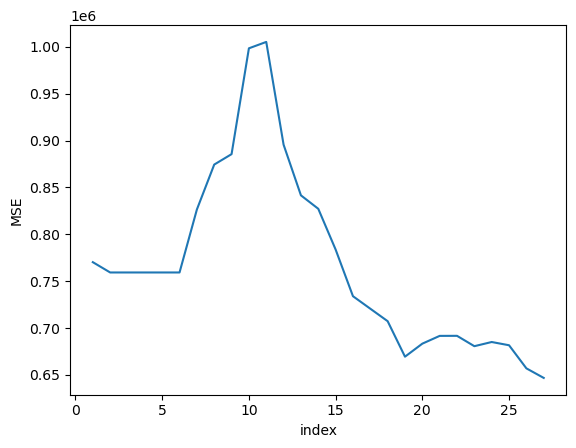

In [182]:
sns.lineplot(data = validation, x = 'index', y = 'MSE')

<Axes: xlabel='index', ylabel='RMSE'>

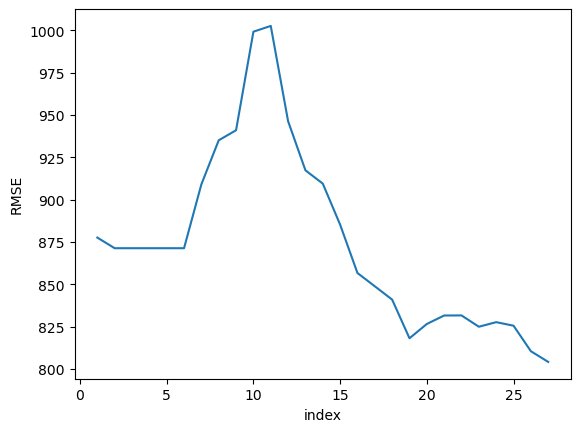

In [183]:
sns.lineplot(data = validation, x = 'index', y = 'RMSE')

<Axes: xlabel='index', ylabel='ABSE'>

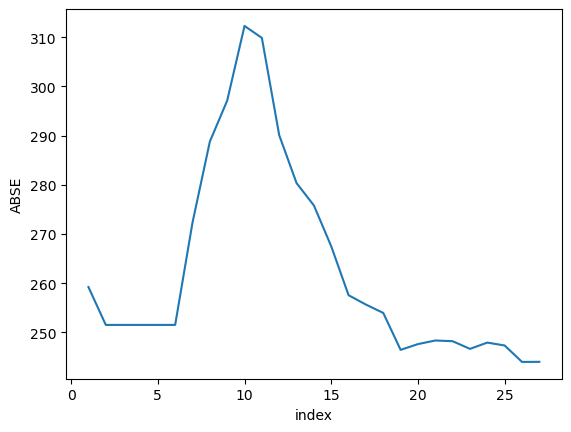

In [184]:
sns.lineplot(data = validation, x = 'index', y = 'ABSE')

#### Forecasting the final test dataset

In [202]:
### Preparing the test data
df_test = pd.read_csv('/kaggle/input/store-sales-2/df_test.csv')

df_test['store_nbr'] = df_test['store_nbr'].apply(str)
df_test['Holiday'] = df_test['Holiday_type'].apply(func)
df_test['Feature'] = df_test['store_nbr'] + '_' + df_test['family'] + '_' + df_test['Holiday']

test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

test_id = test['id']
df_test = pd.concat([test_id, df_test], axis = 1)
df_test = df_test[['id', 'date', 'Oil Price', 'Feature']]
df_test = df_test.drop('Oil Price', axis = 1)

df_test['date_day'] = df_test['date'].apply(lambda x: int(x[-2:])-16)

In [190]:
df_train = pd.read_csv('/kaggle/input/store-sales-8/df_train_pivot (1).csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')
df_train = df_train.asfreq('D')

In [194]:
#Transforming of data into stationary + Saving trend and seasonality in dataframe
trend = pd.DataFrame()
season = pd.DataFrame()
stationary = pd.DataFrame()

date = df_train.index
train_copy = df_train

for col in list(train_copy.columns):
    decomp = seasonal_decompose(train_copy[col], model='additive', extrapolate_trend = 'freq')
    trend[f"{col}"] = decomp.trend
    season[f"{col}"] = decomp.seasonal
    stationary[f"{col}"] = decomp.resid
    
#Save trend mean to add later
trend_mean=trend.mean().tolist() 

#Fill up missing values in each column with mean
trend=trend.fillna(trend.mean())

In [200]:
model = VAR(stationary)
results = model.fit(26)
lag_order = results.k_ar

forecast_input = stationary.values[-lag_order:]

# Forecast the next 16 steps
forecast = pd.DataFrame(results.forecast(y=forecast_input, steps=16))
forecast_values=forecast.tail(16)
forecast_values = forecast_values.rename(columns=dict(zip(forecast_values.columns, list(season.columns))))

#Add back the trend and seasonality to obtain the final sales

final=forecast_values.add(season.tail(16).reset_index(drop=True))
final=final.add(trend_mean)

In [204]:
# Apply the function to create the 'sales' column
df_test['sales'] = df_test.apply(get_sales, axis=1)

df_test = df_test.drop(['date','Feature','date_day'],axis=1)

In [205]:
df_test.to_csv('submission_VAR_26.csv', index = False)

#### Encoding the categorical variables

In [ ]:
df_train = df_train.drop(['Month','Year','Day'], axis = 1)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')


df_test = df_test.drop(['Month','Year','Day'], axis = 1)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('date')

df_val = df_val.drop(['Month','Year','Day'], axis = 1)
df_val['date'] = pd.to_datetime(df_val['date'])
df_val = df_val.set_index('date')

In [ ]:
### Categorical Variables to be encoded
#family
#city
#state
#store_type
#Holiday_type
#locale
#transferred

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
### family
encoder = LabelEncoder()
encoder.fit(df_train['family'])
family_train = encoder.transform(df_train['family'])

encoder = LabelEncoder()
encoder.fit(df_test['family'])
family_test = encoder.transform(df_test['family'])

encoder = LabelEncoder()
encoder.fit(df_val['family'])
family_val = encoder.transform(df_val['family'])

df_train = df_train.drop('family', axis = 1)
df_train['family'] = family_train
df_test = df_test.drop('family', axis = 1)
df_test['family'] = family_test
df_val = df_val.drop('family', axis = 1)
df_val['family'] = family_val

### city
encoder = LabelEncoder()
encoder.fit(df_train['city'])
family_train = encoder.transform(df_train['city'])

encoder = LabelEncoder()
encoder.fit(df_test['city'])
family_test = encoder.transform(df_test['city'])

encoder = LabelEncoder()
encoder.fit(df_val['city'])
family_val = encoder.transform(df_val['city'])

df_train = df_train.drop('city', axis = 1)
df_train['city'] = family_train
df_test = df_test.drop('city', axis = 1)
df_test['city'] = family_test
df_val = df_val.drop('city', axis = 1)
df_val['city'] = family_val

### state
encoder = LabelEncoder()
encoder.fit(df_train['state'])
family_train = encoder.transform(df_train['state'])

encoder = LabelEncoder()
encoder.fit(df_test['state'])
family_test = encoder.transform(df_test['state'])

encoder = LabelEncoder()
encoder.fit(df_val['state'])
family_val = encoder.transform(df_val['state'])

df_train = df_train.drop('state', axis = 1)
df_train['state'] = family_train
df_test = df_test.drop('state', axis = 1)
df_test['state'] = family_test
df_val = df_val.drop('state', axis = 1)
df_val['state'] = family_val

### store type
encoder = LabelEncoder()
encoder.fit(df_train['store_type'])
family_train = encoder.transform(df_train['store_type'])

encoder = LabelEncoder()
encoder.fit(df_test['store_type'])
family_test = encoder.transform(df_test['store_type'])

encoder = LabelEncoder()
encoder.fit(df_val['store_type'])
family_val = encoder.transform(df_val['store_type'])

df_train = df_train.drop('store_type', axis = 1)
df_train['store_type'] = family_train
df_test = df_test.drop('store_type', axis = 1)
df_test['store_type'] = family_test
df_val = df_val.drop('store_type', axis = 1)
df_val['store_type'] = family_val

### Holiday type
encoder = LabelEncoder()
encoder.fit(df_train['Holiday_type'])
family_train = encoder.transform(df_train['Holiday_type'])

encoder = LabelEncoder()
encoder.fit(df_test['Holiday_type'])
family_test = encoder.transform(df_test['Holiday_type'])

encoder = LabelEncoder()
encoder.fit(df_val['Holiday_type'])
family_val = encoder.transform(df_val['Holiday_type'])

df_train = df_train.drop('Holiday_type', axis = 1)
df_train['Holiday_type'] = family_train
df_test = df_test.drop('Holiday_type', axis = 1)
df_test['Holiday_type'] = family_test
df_val = df_val.drop('Holiday_type', axis = 1)
df_val['Holiday_type'] = family_val

### locale
encoder = LabelEncoder()
encoder.fit(df_train['locale'])
family_train = encoder.transform(df_train['locale'])

encoder = LabelEncoder()
encoder.fit(df_test['locale'])
family_test = encoder.transform(df_test['locale'])

encoder = LabelEncoder()
encoder.fit(df_val['locale'])
family_val = encoder.transform(df_val['locale'])

df_train = df_train.drop('locale', axis = 1)
df_train['locale'] = family_train
df_test = df_test.drop('locale', axis = 1)
df_test['locale'] = family_test
df_val = df_val.drop('locale', axis = 1)
df_val['locale'] = family_val

### Transferred
encoder = LabelEncoder()
encoder.fit(df_train['transferred'])
family_train = encoder.transform(df_train['transferred'])

encoder = LabelEncoder()
encoder.fit(df_test['transferred'])
family_test = encoder.transform(df_test['transferred'])

encoder = LabelEncoder()
encoder.fit(df_val['transferred'])
family_val = encoder.transform(df_val['transferred'])

df_train = df_train.drop('transferred', axis = 1)
df_train['transferred'] = family_train
df_test = df_test.drop('transferred', axis = 1)
df_test['transferred'] = family_test
df_val = df_val.drop('transferred', axis = 1)
df_val['transferred'] = family_val

In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

In [ ]:
df_test = df_test.drop('sales', axis = 1)

In [ ]:
df_train.to_csv('df_train_modified.csv')
df_test.to_csv('df_test_modified.csv')
df_val.to_csv('df_val_modified.csv')

#### Model Training

In [4]:
df_train_modified = pd.read_csv('/kaggle/input/store-sales-3/df_train_modified.csv')
df_test_modified = pd.read_csv('/kaggle/input/store-sales-3/df_test_modified.csv')
df_val_modified = pd.read_csv('/kaggle/input/store-sales-3/df_val_modified.csv')

In [6]:
df_train_modified.head()

,date,store_nbr,sales,onpromotion,cluster,Oil Price,family,city,state,store_type,Holiday_type,locale,transferred
0,2013-01-01,1,0.0,0,13,93.102763,0,18,12,3,3,1,0
1,2013-01-01,33,0.0,0,3,93.102763,32,17,9,2,3,1,0
2,2013-01-01,1,0.0,0,13,93.102763,1,18,12,3,3,1,0
3,2013-01-01,1,0.0,0,13,93.102763,2,18,12,3,3,1,0
4,2013-01-01,1,0.0,0,13,93.102763,3,18,12,3,3,1,0


In [6]:
df_val_modified.head()

,date,store_nbr,sales,onpromotion,cluster,Oil Price,family,city,state,store_type,Holiday_type,locale,transferred
0,2017-08-10,1,114.000,0,13,48.54,10,18,12,3,0,1,1
1,2017-08-10,1,10.000,1,13,48.54,2,18,12,3,0,1,1
2,2017-08-10,1,2377.000,6,13,48.54,3,18,12,3,0,1,1
3,2017-08-10,1,0.000,0,13,48.54,4,18,12,3,0,1,1
4,2017-08-10,1,417.021,10,13,48.54,5,18,12,3,0,1,1


In [7]:
df_test_modified.head()

,date,store_nbr,onpromotion,cluster,Oil Price,family,city,state,store_type,Holiday_type,locale,transferred
0,2017-08-16,1,0,13,46.8,14,18,12,3,1,1,0
1,2017-08-16,1,12,13,46.8,5,18,12,3,1,1,0
2,2017-08-16,1,0,13,46.8,6,18,12,3,1,1,0
3,2017-08-16,1,25,13,46.8,7,18,12,3,1,1,0
4,2017-08-16,1,45,13,46.8,8,18,12,3,1,1,0


1) Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

In [ ]:
df_train_modified = df_train_modified.drop('date', axis = 1)
df_val_modified = df_val_modified.drop('date', axis = 1)
df_test_modified = df_test_modified.drop('date', axis = 1)

X_train = df_train_modified.drop('sales', axis = 1)
y_train = df_train_modified['sales']

X_val = df_val_modified.drop('sales', axis = 1)
y_val = df_val_modified['sales']

In [7]:
print(X_train.shape)
print(X_val.shape)
print(df_test_modified.shape)
print(y_train.shape)
print(y_val.shape)

(2997324, 11)
(10692, 11)
(28512, 11)
(2997324,)
(10692,)


In [12]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [13]:
# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 488.1670650719429
Mean Squared Error (MSE): 918456.932157913
Root Mean Squared Error (RMSE): 958.3615873760347


In [8]:
df_test = df_test_modified
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
test_id = test['id']
df_test['id'] = test_id
X_test = df_test.drop('id',axis = 1)

In [15]:
pred_sub = model.predict(X_test)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_LR.csv')

2) Ridge Regression

In [234]:
from sklearn.linear_model import Ridge

In [235]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [236]:
# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 488.16833537949014
Mean Squared Error (MSE): 918456.8418090552
Root Mean Squared Error (RMSE): 958.3615402388888


In [238]:
pred_sub = model.predict(X_test)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_Ridge.csv')

3) Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_val)

# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

pred_sub = model.predict(df_test_modified)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_DecisionTree.csv')

4) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_val)

# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

pred_sub = model.predict(df_test_modified)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_RandomForest.csv')

5) KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_val)

# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

pred_sub = model.predict(df_test_modified)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_KNN.csv')

6) SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
model = SVR()
model.fit(X_train, y_train)
pred = model.predict(X_val)

# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

pred_sub = model.predict(df_test_modified)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_SVM.csv')

7) XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_val)

# Calculate evaluation metrics
mae = np.mean(np.abs(pred - y_val))
mse = np.mean((pred - y_val) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

pred_sub = model.predict(df_test_modified)

index_id = df_test['id']
submission = pd.DataFrame()
submission['id'] = index_id
submission['sales'] = pred_sub

submission.to_csv('submission_XGB.csv')

### Deep Learning

1) Multi Layer Perceptron Model (MLP)

In [9]:
import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.callbacks import EarlyStopping 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [14]:
epochs = 35
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(2997324, 11)
(28512, 11)
(10692, 11)
(2997324,)
(10692,)


In [10]:
X = X_train + X_val
y = y_train + y_val

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [15]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#mlp_history = model_mlp.fit(X.values, y, validation_data=(X_val.values, y_val), epochs=epochs, verbose=1)
mlp_history = model_mlp.fit(X.values, y, epochs=epochs, verbose=1)

Epoch 1/35
93667/93667 [==============================] - 155s 2ms/step - loss: nan
Epoch 2/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 3/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 4/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 5/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 6/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 7/35
93667/93667 [==============================] - 154s 2ms/step - loss: nan
Epoch 8/35
83902/93667 [=========================>....] - ETA: 16s - loss: nan

In [1]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_val.values)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, mlp_valid_pred)))

NameError: name 'model_mlp' is not defined

2) CNN for forecasting

In [12]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (2997324, 11, 1)
Validation set shape (10692, 11, 1)


In [15]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 10, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                16050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
__________________________________________________

In [3]:
pip install clipboard

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement clipboard (from versions: none)
ERROR: No matching distribution found for clipboard


In [17]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_valid_series, y_val), epochs=epochs, verbose=2)

Epoch 1/35
93667/93667 - 228s - loss: 921894.8750 - val_loss: 819785.3750 - 228s/epoch - 2ms/step
Epoch 2/35
93667/93667 - 221s - loss: 878296.7500 - val_loss: 797922.7500 - 221s/epoch - 2ms/step
Epoch 3/35
93667/93667 - 221s - loss: 840497.6875 - val_loss: 763620.4375 - 221s/epoch - 2ms/step
Epoch 4/35
93667/93667 - 221s - loss: 812501.4375 - val_loss: 732189.8125 - 221s/epoch - 2ms/step
Epoch 5/35
93667/93667 - 220s - loss: 798510.5625 - val_loss: 752235.8750 - 220s/epoch - 2ms/step
Epoch 6/35
93667/93667 - 221s - loss: 790271.4375 - val_loss: 749208.2500 - 221s/epoch - 2ms/step
Epoch 7/35
93667/93667 - 222s - loss: 784551.2500 - val_loss: 734390.3750 - 222s/epoch - 2ms/step
Epoch 8/35
93667/93667 - 221s - loss: 779320.1250 - val_loss: 708121.5000 - 221s/epoch - 2ms/step
Epoch 9/35
93667/93667 - 223s - loss: 773084.1875 - val_loss: 715897.6250 - 223s/epoch - 2ms/step
Epoch 10/35
93667/93667 - 222s - loss: 767365.6875 - val_loss: 705431.6250 - 222s/epoch - 2ms/step
Epoch 11/35
93667/9

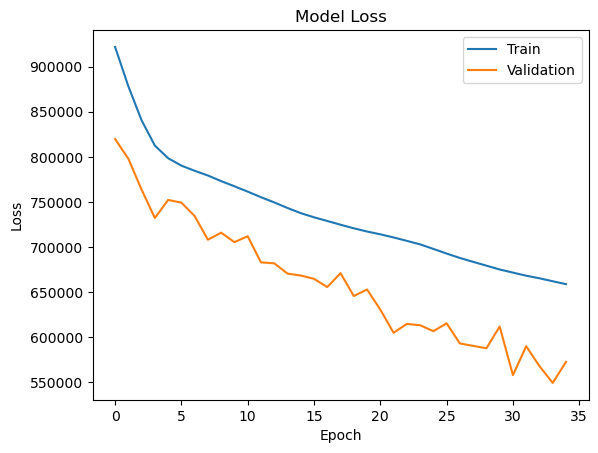

In [41]:
plt.plot(cnn_history.history['loss'], label='Train')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [20]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, cnn_valid_pred)))

335/335 [==============================] - 1s 2ms/step
Train rmse: 816.2809843156908
Validation rmse: 756.7608860783265


In [22]:
#X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [23]:
cnn_test_pred = model_cnn.predict(X_test_series)

891/891 [==============================] - 2s 2ms/step


In [28]:
cnn_test_pred = pd.DataFrame(cnn_test_pred, columns = ['sales'])
test_id = pd.DataFrame(test_id)
submission_pred = pd.concat([test_id, cnn_test_pred], axis = 1)
submission_pred_cnn = submission_pred

In [35]:
submission_pred_cnn.to_csv('submission_pred_cnn.csv', index = False)

3) LSTM for time seriess forecasting

In [42]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_valid_series, y_val), epochs=45, verbose=2)

Epoch 1/45
93667/93667 - 1893s - loss: 790375.8750 - val_loss: 474709.2500 - 1893s/epoch - 20ms/step
Epoch 2/45
93667/93667 - 1881s - loss: 528892.2500 - val_loss: 386239.6250 - 1881s/epoch - 20ms/step
Epoch 3/45


In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

4) CNN LSTM 

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))